# Stocks Price Prediction

In [141]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [143]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
print(start)

2015-09-10 00:00:00


In [144]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_26296/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000
2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000


In [145]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [146]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000


In [147]:
data.shape

(2515, 6)

In [148]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [149]:
data.duplicated().sum()

np.int64(0)

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2515 non-null   object 
 1   Close   2515 non-null   float64
 2   High    2515 non-null   float64
 3   Low     2515 non-null   float64
 4   Open    2515 non-null   float64
 5   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.0+ KB


In [151]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
2505,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
2506,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
2507,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
2508,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
2509,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
2510,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
2511,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
2512,2025-09-08,234.160004,238.399994,233.729996,235.789993,23128800
2513,2025-09-09,239.940002,240.589996,233.380005,234.190002,22815200
2514,2025-09-10,241.419998,242.080002,238.179993,239.320007,11075372


In [152]:
data.describe()

,Close,High,Low,Open,Volume
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,92.763685,93.722494,91.759802,92.696583,2.955394e+07
std,48.377961,48.912932,47.819079,48.332259,1.417402e+07
min,29.542332,30.044399,29.268705,29.661023,6.809800e+06
25%,52.073647,52.696635,51.375673,52.114613,2.064800e+07
50%,75.815674,77.569170,75.216279,75.790345,2.613000e+07
75%,133.605942,135.008115,132.037429,133.488999,3.409000e+07
max,241.419998,242.080002,238.179993,239.320007,1.330780e+08


In [153]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000


In [154]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [155]:
# adding log returns and pct returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data['Pct_Returns'] = data['Close'].pct_change()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000,NaN,NaN
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269,-0.020065
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530,-0.000530


In [156]:
data.isnull().sum()

Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
Log_Returns    1
Pct_Returns    1
dtype: int64

In [157]:
data.shape

(2515, 8)

In [158]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2015-09-10,30.856342,30.995888,30.363715,30.446647,38106000,NaN,NaN
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323


In [159]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269,-0.020065
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530,-0.000530
10,2015-09-24,31.077332,31.152813,30.411885,30.622444,44802000,0.005512,0.005527


In [160]:
data.shape

(2514, 8)

In [161]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [162]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    2514.000000
mean        0.000818
std         0.018053
min        -0.117667
25%        -0.007165
50%         0.001389
75%         0.010055
max         0.099380
Name: Log_Returns, dtype: float64

Skewness: -0.18789856431751772
Kurtosis: 4.762824206349595


In [163]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -16.865222658474735
p-value: 1.0918031101661348e-29
Critical Value 1%: -3.4329631791044304
Critical Value 5%: -2.8626944896608433
Critical Value 10%: -2.5673845793841457


In [164]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114,NaN
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043,NaN
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094,NaN
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323,NaN
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881,NaN
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232,NaN
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837,NaN
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269,-0.020065,NaN
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530,-0.000530,NaN
10,2015-09-24,31.077332,31.152813,30.411885,30.622444,44802000,0.005512,0.005527,NaN


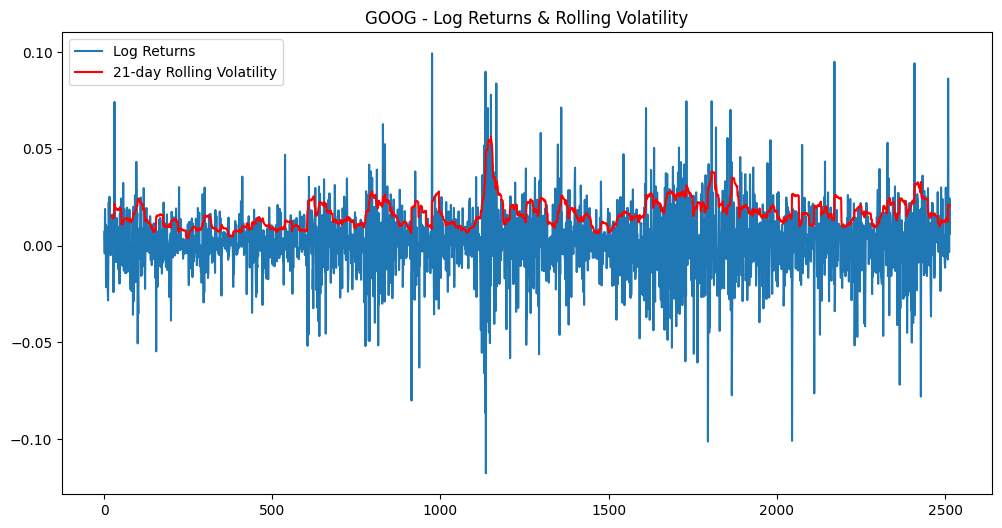

In [165]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

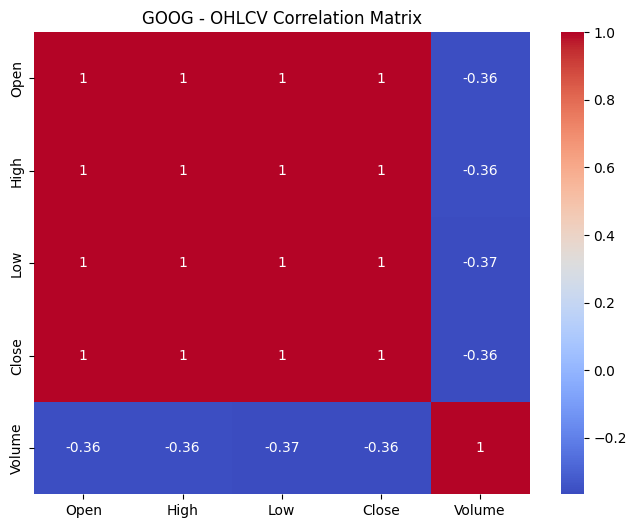

In [166]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()

In [167]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114,NaN
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043,NaN
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094,NaN
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323,NaN
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881,NaN
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232,NaN
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837,NaN
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269,-0.020065,NaN
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530,-0.000530,NaN
10,2015-09-24,31.077332,31.152813,30.411885,30.622444,44802000,0.005512,0.005527,NaN


In [168]:
data = data.drop("Rolling_Vol", axis=1)
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881


In [169]:
data.shape

(2514, 8)

### Remark:
    So far in my data i have added the Log_Returns and Pct_Returns features
    in a few i will be adding other features such as macd, bollinger, rsi, sma/ema features

In [170]:
# simple and exponential moving averages function
def add_moving_averages(data, windows=(5, 10, 20, 50, 200)):
    data = data.copy()
    for window in windows:
        # simple moving average
        data[f"SMA_{window}"] = data["Close"].rolling(window=window, min_periods=1).mean()
        
        # exponential moving average
        data[f"EMA_{window}"] = data["Close"].ewm(span=window, adjust=False).mean()
    
    return data

In [171]:
# relative strength index function
def add_rsi(data, period=14):
    data = data.copy()
    delta = data["Close"].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0)

    ma_up = up.ewm(alpha=1 / period, adjust=False).mean()
    ma_down = down.ewm(alpha=1 / period, adjust=False).mean()

    rs = ma_up / ma_down
    data[f"RSI_{period}"] = 100 - (100 / (1 + rs))

    return data

In [172]:
# moving average convergence divergence function
def add_macd(data, fast=12, slow=26, signal=9):
    data = data.copy()
    ema_fast = data["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = data["Close"].ewm(span=slow, adjust=False).mean()

    data["MACD"] = ema_fast - ema_slow
    data["MACD_Signal"] = data["MACD"].ewm(span=signal, adjust=False).mean()
    data["MACD_Hist"] = data["MACD"] - data["MACD_Signal"]

    return data

In [173]:
# bollinger bands function
def add_bollinger_bands(data, window=20, n_std=2):
    data = data.copy()

    sma = data["Close"].rolling(window=window).mean()
    rstd = data["Close"].rolling(window=window).std()

    data[f"BB_MID_{window}"] = sma
    data[f"BB_UP_{window}"] = sma + n_std * rstd
    data[f"BB_LOW_{window}"] = sma - n_std * rstd

    return data

In [174]:
# on-balance volume (obv)
def add_obv(data):
    data = data.copy()

    sign = np.sign(data["Close"].diff()).fillna(0)
    data["OBV"] = (sign * data["Volume"]).cumsum()

    return data

In [175]:
# vwap (daily rolling)
def add_vwap(data, window=14):
    data = data.copy()

    typical_price = (data["High"] + data["Low"] + data["Close"]) / 3
    vol = data["Volume"]
    vwap = (typical_price * vol).rolling(window=window).sum() / vol.rolling(window=window).sum()
    data[f"VWAP_{window}"] = vwap

    return data

In [176]:
# lags and rolling volatility
def add_lags_rollings(data, lag_list=(1, 2, 3, 4, 5), rolling_windows=(5, 10, 21)):
    data = data.copy()

    if "Log_Returns" not in data:
        data['Pct_Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    for l in lag_list:
        data[f'LogRet_lag_{l}'] = data['Log_Returns'].shift(l)

    for w in rolling_windows:
        data[f'RollMean_{w}'] = data['Log_Returns'].rolling(window=w).mean()
        data[f'RollVol_{w}'] = data['Log_Returns'].rolling(window=w).std()
    return data

In [177]:
# add all features
def add_all_features(data):
    data = data.copy()
    data = add_moving_averages(data)
    data = add_rsi(data)
    data = add_macd(data)
    data = add_bollinger_bands(data)
    data = add_obv(data)
    data = add_vwap(data)
    data = add_lags_rollings(data)
    data = data.dropna()
    return data

In [178]:
# adding all features
features = add_all_features(data)
print(features.head(10))

         Date      Close       High        Low       Open    Volume  \
21 2015-10-09  31.961779  32.079969  31.549996  31.782505  32974000   
22 2015-10-12  32.113739  32.204616  31.733343  31.886295  25504000   
23 2015-10-13  32.393326  32.667049  31.938935  31.938935  36154000   
24 2015-10-14  32.336708  32.745414  32.221995  32.438512  28310000   
25 2015-10-15  32.862114  32.931142  32.500586  32.510520  37714000   
26 2015-10-16  32.884956  33.022515  32.636656  32.979808  32222000   
27 2015-10-19  33.078636  33.114391  32.754852  32.834306  29546000   
28 2015-10-20  32.293011  33.010104  31.990830  32.976334  49964000   
29 2015-10-21  31.912119  32.570611  31.868415  32.485197  35822000   
30 2015-10-22  32.367996  32.666453  31.981640  32.115225  81420000   

    Log_Returns  Pct_Returns      SMA_5      EMA_5  ...  LogRet_lag_2  \
21     0.006938     0.006962  31.902087  31.716945  ...     -0.004783   
22     0.004743     0.004754  31.953734  31.849209  ...     -0.004994   

In [179]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-11,31.075842,31.076338,30.661180,30.776887,27470000,0.007088,0.007114
2,2015-09-14,30.950199,31.080307,30.760994,31.072362,34046000,-0.004051,-0.004043
3,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
4,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
5,2015-09-17,31.926519,32.323798,31.535196,31.672755,45494000,0.010822,0.010881
6,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021461,-0.021232
7,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
8,2015-09-22,30.922886,31.164234,30.562352,31.136921,51258000,-0.020269,-0.020065
9,2015-09-23,30.906500,31.232768,30.789302,30.891106,29418000,-0.000530,-0.000530
10,2015-09-24,31.077332,31.152813,30.411885,30.622444,44802000,0.005512,0.005527


In [180]:
# adding all the features into the data
data = add_all_features(data)
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,SMA_5,EMA_5,...,LogRet_lag_2,LogRet_lag_3,LogRet_lag_4,LogRet_lag_5,RollMean_5,RollVol_5,RollMean_10,RollVol_10,RollMean_21,RollVol_21
21,2015-10-09,31.961779,32.079969,31.549996,31.782505,32974000,0.006938,0.006962,31.902087,31.716945,...,-0.004783,0.006170,0.022959,0.025232,0.005258,0.011434,0.005041,0.016217,0.001676,0.015170
22,2015-10-12,32.113739,32.204616,31.733343,31.886295,25504000,0.004743,0.004754,31.953734,31.849209,...,-0.004994,-0.004783,0.006170,0.022959,0.001615,0.005989,0.008346,0.011282,0.001564,0.015137
23,2015-10-13,32.393326,32.667049,31.938935,31.938935,36154000,0.008668,0.008706,32.021868,32.030582,...,0.006938,-0.004994,-0.004783,0.006170,0.002114,0.006543,0.009199,0.010909,0.002170,0.015155
24,2015-10-14,32.336708,32.745414,32.221995,32.438512,28310000,-0.001749,-0.001748,32.109268,32.132624,...,0.004743,0.006938,-0.004994,-0.004783,0.002721,0.005847,0.006789,0.010327,0.001186,0.014677
25,2015-10-15,32.862114,32.931142,32.500586,32.510520,37714000,0.016117,0.016248,32.333533,32.375787,...,0.008668,0.004743,0.006938,-0.004994,0.006944,0.006472,0.007930,0.010695,0.001891,0.015035
26,2015-10-16,32.884956,33.022515,32.636656,32.979808,32222000,0.000695,0.000695,32.518169,32.545510,...,-0.001749,0.008668,0.004743,0.006938,0.005695,0.007050,0.005476,0.008958,0.001408,0.014896
27,2015-10-19,33.078636,33.114391,32.754852,32.834306,29546000,0.005872,0.005890,32.711148,32.723219,...,0.016117,-0.001749,0.008668,0.004743,0.005921,0.007030,0.003768,0.006562,0.002710,0.013962
28,2015-10-20,32.293011,33.010104,31.990830,32.976334,49964000,-0.024037,-0.023750,32.691085,32.579816,...,0.000695,0.016117,-0.001749,0.008668,-0.000620,0.014779,0.000747,0.010871,0.001099,0.015016
29,2015-10-21,31.912119,32.570611,31.868415,32.485197,35822000,-0.011865,-0.011795,32.606167,32.357250,...,0.005872,0.000695,0.016117,-0.001749,-0.002643,0.015639,0.000039,0.011485,0.001499,0.014522
30,2015-10-22,32.367996,32.666453,31.981640,32.115225,81420000,0.014184,0.014285,32.507344,32.360832,...,-0.024037,0.005872,0.000695,0.016117,-0.003030,0.015073,0.001957,0.012134,0.002200,0.014772


In [181]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns',
       'Pct_Returns', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'OBV',
       'VWAP_14', 'LogRet_lag_1', 'LogRet_lag_2', 'LogRet_lag_3',
       'LogRet_lag_4', 'LogRet_lag_5', 'RollMean_5', 'RollVol_5',
       'RollMean_10', 'RollVol_10', 'RollMean_21', 'RollVol_21'],
      dtype='object')

In [182]:
data = data.copy()

# next day target
data["Target_Close"] = data["Close"].shift(-1)

# next day log returns
data["Target_LogRet"] = data["Log_Returns"].shift(-1)

# next-day up/down (classification)
features["Target_Up"] = (features["Close"].shift(-1) > features["Close"]).astype(int)

# drop last row (NaN targets)
features = features.dropna()

In [ ]:
data.head()